# Statistical measure of gyre strength

### Notebook setup

In [1]:
import cartopy.crs as ccrs
import cosima_cookbook as cc
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean as cm
from dask.distributed import Client
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)

# matplotlib stuff:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rc('xtick', labelsize = 20) 
matplotlib.rc('ytick', labelsize = 20)

from gsw import SA_from_SP, p_from_z, CT_from_pt, rho
from gsw import rho
import xgcm

from sklearn import preprocessing

from xhistogram.xarray import histogram

In [2]:
import logging
logger = logging.getLogger("distributed.utils_perf")
logger.setLevel(logging.ERROR)

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 251.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40195,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 251.21 GiB
Comm: tcp://127.0.0.1:35647,Total threads: 4
Dashboard: /proxy/41539/status,Memory: 62.80 GiB
Nanny: tcp://127.0.0.1:39091,


In [4]:
db = '/scratch/x77/db6174/mom/archive/databases/025deg_jra55_ryf/cc_database_control.db'
session = cc.database.create_session(db)

In [5]:
expt = '025deg_jra55_ryf_control'

### Estimating streamfunction

In [6]:
ncoarse = 12

x_min = [-100, -250]
x_max = [ 10 , -100]
y_min = [ 20 ,  20 ]
y_max = [ 75 ,  75 ]
basin = ['NA', 'NP']

k = 0

In [ ]:
#start_time = '2203-01-01'
#end_time = '2301-12-31'

In [8]:
hist_cont = np.zeros((20, 21))

In [9]:
rho0 = 1026
pt_max = 1036
year_intv = 5

#area_t = cc.querying.getvar(expt = expt, session = session, variable = 'area_t', n = 1).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
#area_u = cc.querying.getvar(expt = expt, session = session, variable = 'area_u', n = 1).sel(xu_ocean = slice(x_min[k], x_max[k])).sel(yu_ocean = slice(y_min[k], y_max[k]))
#T = cc.querying.getvar(expt = expt, session = session, variable = 'surface_temp', n = 1).sel(xt_ocean = slice(x_min[k], x_max[k])).sel(yt_ocean = slice(y_min[k], y_max[k]))
#T = T.mean('time')

ty_trans = cc.querying.getvar(expt = expt, session = session, variable = 'ty_trans_int_z', n = 1, use_cftime = True)
ty_trans = ty_trans.mean('time')

#bmin = 0
#bmax = 100
#bins = np.linspace(bmin, bmax, (bmax - bmin + 1))

quantiles = np.linspace(0, 1, 21)

#area_t = area_t.fillna(0)
#area_t_normalize = preprocessing.normalize(area_t)
#area_t_normalize = (area_t_normalize * T)/T

for i in range(0, 100, year_intv):
    start_year = 2203 + i
    end_year = start_year + (year_intv - 1)
    start_time = str(start_year) + '-01-01'
    end_time = str(end_year) + '-12-31'
    ty_trans_rho = cc.querying.getvar(expt = expt, session = session, variable = 'ty_trans_rho', frequency = '1 monthly', 
                                      start_time = start_time, end_time = end_time, use_cftime = True).sel(time = slice(start_time, end_time))
    ty_trans_rho = ty_trans_rho.sel(potrho = slice(1028, pt_max))
    ty_basin = ty_trans_rho.sel(grid_xt_ocean = slice(x_min[k], x_max[k])).sel(grid_yu_ocean = slice(y_min[k], y_max[k]))
    psi_basin = ty_basin.cumsum('grid_xt_ocean').where(abs(ty_basin<=1.e20))/(rho0*1.e6)
    
    psi = psi_basin.mean('time').sum('potrho')
    psi = psi.rename('Subtropical gyre streamfunction')
    psi = psi.rename({'grid_xt_ocean': 'xt_ocean','grid_yu_ocean': 'yu_ocean'})
    psi = psi.where(~np.isnan(ty_trans))
    
    y_shape, x_shape = psi.shape

    #whist = histogram(psi, bins = bins, weights = area_t_normalize)
    psi_chunked = psi.chunk(chunks = {'yu_ocean':y_shape, 'xt_ocean':x_shape}).persist()
    hist_cont[int(i/5), :] = psi_chunked.quantile(quantiles, dim = {"xt_ocean", "yu_ocean"}).values

In [10]:
time_array = np.linspace(2, 97, 20)
data = xr.DataArray(hist_cont, coords = [time_array, quantiles * 100],  
                           dims = ['time', 'percentile'], name = 'Probability distribution function', attrs = {'units':'Sv / m^2'})

In [11]:
dataset = data.to_dataset()
dataset.to_netcdf(path = '/g/data/x77/db6174/Varying_surface_forcing/025deg_flux_forced_uniform/netCDF/Quantiles_pdf_distribution/quantiles_control.nc', 
                  mode = 'w', format = "NETCDF4", engine = "netcdf4")

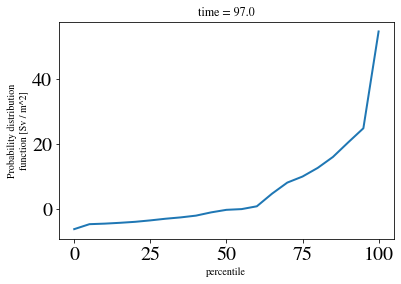

In [14]:
data.sel(time = 97).plot()